<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_id           1000 non-null   object 
 1   title             1000 non-null   object 
 2   description       1000 non-null   object 
 3   priority          1000 non-null   object 
 4   status            1000 non-null   object 
 5   assignee          1000 non-null   object 
 6   project           1000 non-null   object 
 7   created_date      1000 non-null   object 
 8   due_date          1000 non-null   object 
 9   completed_date    205 non-null    object 
 10  tags              1000 non-null   object 
 11  estimated_hours   1000 non-null   int64  
 12  actual_hours      205 non-null    float64
 13  dependencies      189 non-null    object 
 14  progress_percent  1000 non-null   int64  
 15  comments_count    1000 non-null   int64  
 16  last_updated      1000 non-null   object 
d

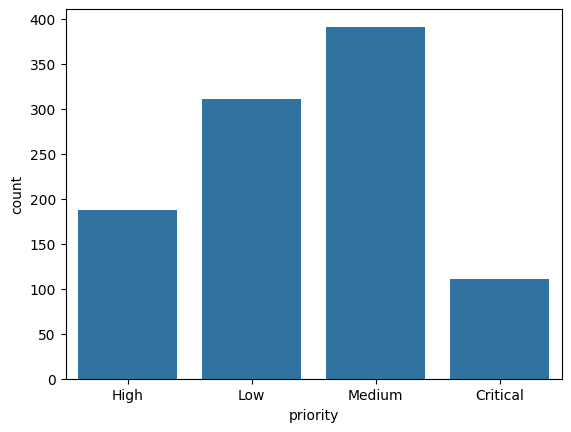

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\AI_Task_Management\Data\dataset.csv")
print(df.info())
print(df.describe())

sns.countplot(x="priority", data=df)
plt.show()


In [3]:
import pandas as pd
import re
import nltk
import warnings
warnings.filterwarnings("ignore")  # suppress nltk / future warnings

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# 1️⃣ Load dataset
df = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\AI_Task_Management\Data\dataset.csv")
print("Columns:", df.columns.tolist())

# 2️⃣ Download NLTK resources quietly
for pkg in ["punkt", "stopwords", "wordnet"]:
    try:
        nltk.data.find(f"tokenizers/{pkg}") if pkg == "punkt" else nltk.data.find(f"corpora/{pkg}")
    except LookupError:
        nltk.download(pkg, quiet=True)

# 3️⃣ Combine title + description
df["text"] = df[["title", "description"]].fillna("").astype(str).agg(" ".join, axis=1)

# 4️⃣ Preprocess text
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(raw):
    text = str(raw).lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)

# 5️⃣ Show a preview
print(df[["title", "clean_text"]].head())

# 6️⃣ Save cleaned dataset
output_path = r"C:\Users\DELL\OneDrive\Desktop\AI_Task_Management\Data\tasks_cleaned.csv"
df.to_csv(output_path, index=False)
print(f"✅ Cleaned dataset saved as: {output_path}")


Columns: ['task_id', 'title', 'description', 'priority', 'status', 'assignee', 'project', 'created_date', 'due_date', 'completed_date', 'tags', 'estimated_hours', 'actual_hours', 'dependencies', 'progress_percent', 'comments_count', 'last_updated']
                          title  \
0        Annotate training data   
1         Create task scheduler   
2     Integrate payment gateway   
3  Fix production bug - payment   
4       Deploy model to staging   

                                          clean_text  
0           annotate training data data pipeline etl  
1       create task scheduler documentation handover  
2          integrate payment gateway testing qa task  
3  fix production bug payment frontend design int...  
4     deploy model staging model training evaluation  
✅ Cleaned dataset saved as: C:\Users\DELL\OneDrive\Desktop\AI_Task_Management\Data\tasks_cleaned.csv


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 1️⃣ Load the cleaned dataset
df = pd.read_csv("tasks_cleaned.csv")
print("✅ Dataset loaded successfully!")
print("Columns available:", df.columns.tolist())

# 2️⃣ Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000,   # Limit to 1000 top words (optional for performance)
    ngram_range=(1,2),   # Use unigrams + bigrams (optional but helps context)
    stop_words='english' # Automatically remove English stopwords
)

# 3️⃣ Fit and transform the cleaned text
X = vectorizer.fit_transform(df["clean_text"])

# 4️⃣ Select your target variable (Priority or Label)
# 👇 Make sure 'priority' column exists in your CSV
y = df["priority"]

# 5️⃣ Print useful info to verify
print("\n✅ TF-IDF feature extraction complete!")
print("Shape of TF-IDF matrix:", X.shape)
print("Number of features (unique words):", len(vectorizer.get_feature_names_out()))
print("Sample feature names:", vectorizer.get_feature_names_out()[:15])

# (Optional) Check first few TF-IDF values as a DataFrame (small datasets only)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print("\n🔹 Sample TF-IDF matrix preview:")
print(tfidf_df.head())


✅ Dataset loaded successfully!
Columns available: ['task_id', 'title', 'description', 'priority', 'status', 'assignee', 'project', 'created_date', 'due_date', 'completed_date', 'tags', 'estimated_hours', 'actual_hours', 'dependencies', 'progress_percent', 'comments_count', 'last_updated', 'text', 'clean_text']

✅ TF-IDF feature extraction complete!
Shape of TF-IDF matrix: (1000, 465)
Number of features (unique words): 465
Sample feature names: ['access' 'access backend' 'access customer' 'access data'
 'access detailed' 'access devops' 'access documentation'
 'access frontend' 'access model' 'access performance' 'access testing'
 'accuracy' 'accuracy backend' 'accuracy customer' 'accuracy data']

🔹 Sample TF-IDF matrix preview:
   access  access backend  access customer  access data  access detailed  \
0     0.0             0.0              0.0          0.0              0.0   
1     0.0             0.0              0.0          0.0              0.0   
2     0.0             0.0         

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 1️⃣ Split the dataset into training and testing sets
# Use 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data split done:")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# ------------------------------------------------------------
# 2️⃣ Train Naive Bayes Classifier
# ------------------------------------------------------------
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# ------------------------------------------------------------
# 3️⃣ Train Support Vector Machine (SVM) Classifier
# ------------------------------------------------------------
svm_model = SVC(kernel='linear')  # 'linear' works well for text data
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# ------------------------------------------------------------
# 4️⃣ Evaluate both models
# ------------------------------------------------------------
def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 {name} Model Evaluation:")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print("Precision:", round(precision_score(y_true, y_pred, average='weighted', zero_division=0), 3))
    print("Recall:", round(recall_score(y_true, y_pred, average='weighted', zero_division=0), 3))
    print("F1 Score:", round(f1_score(y_true, y_pred, average='weighted', zero_division=0), 3))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

# Evaluate both
evaluate_model("Naive Bayes", y_test, y_pred_nb)
evaluate_model("SVM", y_test, y_pred_svm)

# ------------------------------------------------------------
# 5️⃣ Save the better model for later (optional)
# ------------------------------------------------------------
import joblib

joblib.dump(nb_model, "naive_bayes_model.pkl")
joblib.dump(svm_model, "svm_model.pkl")
print("\n✅ Models saved as 'naive_bayes_model.pkl' and 'svm_model.pkl'")


✅ Data split done:
Training samples: 800
Testing samples: 200

📊 Naive Bayes Model Evaluation:
Accuracy: 0.3
Precision: 0.192
Recall: 0.3
F1 Score: 0.234

Classification Report:
               precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        28
        High       0.00      0.00      0.00        42
         Low       0.21      0.30      0.25        56
      Medium       0.36      0.58      0.45        74

    accuracy                           0.30       200
   macro avg       0.14      0.22      0.17       200
weighted avg       0.19      0.30      0.23       200


📊 SVM Model Evaluation:
Accuracy: 0.335
Precision: 0.209
Recall: 0.335
F1 Score: 0.254

Classification Report:
               precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        28
        High       0.00      0.00      0.00        42
         Low       0.25      0.29      0.27        56
      Medium       0.38      0.69      0.49        74

 

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import numpy as np

# 1️⃣ Load your Excel dataset (.xls)
df = pd.read_csv("tasks_cleaned.csv")
print("✅ Loaded Excel file successfully!")
print("Columns in your dataset:", df.columns.tolist())

# 2️⃣ Ensure consistent text column
if "clean_text" not in df.columns:
    # Try to combine title + description if available
    if all(col in df.columns for col in ["title", "description"]):
        df["clean_text"] = df[["title", "description"]].fillna("").astype(str).agg(" ".join, axis=1)
        print("✅ Created 'clean_text' from title + description")
    else:
        print("⚠️ No text columns found. Creating empty 'clean_text' column.")
        df["clean_text"] = ""

# 3️⃣ Handle 'deadline' — create if missing
if "deadline" not in df.columns:
    print("⚠️ 'deadline' column missing — generating synthetic deadlines...")
    today = datetime.now()
    df["deadline"] = [today + timedelta(days=int(x)) for x in np.random.randint(1, 15, len(df))]

# 4️⃣ Calculate 'days_left' feature
def calculate_days_left(deadline):
    try:
        deadline_date = pd.to_datetime(deadline, errors='coerce')
        if pd.isna(deadline_date):
            return None
        today = datetime.now()
        return max((deadline_date - today).days, 0)
    except:
        return None

df["days_left"] = df["deadline"].apply(calculate_days_left)

# 5️⃣ Handle 'workload_hours' — create if missing
if "workload_hours" not in df.columns:
    df["workload_hours"] = np.random.randint(1, 9, size=len(df))
    print("✅ Added synthetic 'workload_hours' column")

# 6️⃣ Handle 'priority' — create or encode
if "priority" not in df.columns:
    print("⚠️ 'priority' column not found — creating random sample priorities (High/Medium/Low).")
    df["priority"] = np.random.choice(["High", "Medium", "Low"], size=len(df))

# Encode priority numerically
le = LabelEncoder()
df["priority_encoded"] = le.fit_transform(df["priority"])
print("✅ Encoded priorities:", list(le.classes_))

# 7️⃣ Fill any missing values safely
df = df.fillna({
    "clean_text": "",
    "days_left": 0,
    "workload_hours": df["workload_hours"].median()
})

# 8️⃣ Save prepared dataset for model training
output_path = r"C:\Users\DELL\OneDrive\Desktop\AI_Task_Management\Data\tasks_prepared.csv"
df.to_csv(output_path, index=False)
print(f"✅ Week 3 Step 1 completed: saved as '{output_path}'")
print(df.head(5))


✅ Loaded Excel file successfully!
Columns in your dataset: ['task_id', 'title', 'description', 'priority', 'status', 'assignee', 'project', 'created_date', 'due_date', 'completed_date', 'tags', 'estimated_hours', 'actual_hours', 'dependencies', 'progress_percent', 'comments_count', 'last_updated', 'text', 'clean_text']
⚠️ 'deadline' column missing — generating synthetic deadlines...
✅ Added synthetic 'workload_hours' column
✅ Encoded priorities: ['Critical', 'High', 'Low', 'Medium']
✅ Week 3 Step 1 completed: saved as 'C:\Users\DELL\OneDrive\Desktop\AI_Task_Management\Data\tasks_prepared.csv'
     task_id                         title                      description  \
0  TASK-0001        Annotate training data            Data pipeline and ETL   
1  TASK-0002         Create task scheduler       Documentation and handover   
2  TASK-0003     Integrate payment gateway             Testing and QA tasks   
3  TASK-0004  Fix production bug - payment  Frontend design and interaction   
4  TA

✅ Loaded dataset with shape: (1000, 23)
Columns: ['task_id', 'title', 'description', 'priority', 'status', 'assignee', 'project', 'created_date', 'due_date', 'completed_date', 'tags', 'estimated_hours', 'actual_hours', 'dependencies', 'progress_percent', 'comments_count', 'last_updated', 'text', 'clean_text', 'deadline', 'days_left', 'workload_hours', 'priority_encoded']
✅ Feature matrix shape: (1000, 101)

🌲 Random Forest Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        38
           2       0.33      0.19      0.24        62
           3       0.37      0.77      0.50        78

    accuracy                           0.36       200
   macro avg       0.18      0.24      0.19       200
weighted avg       0.25      0.36      0.27       200

Accuracy: 0.36

🚀 XGBoost Results:
              precision    recall  f1-score   support

           0       0.00      0.00      

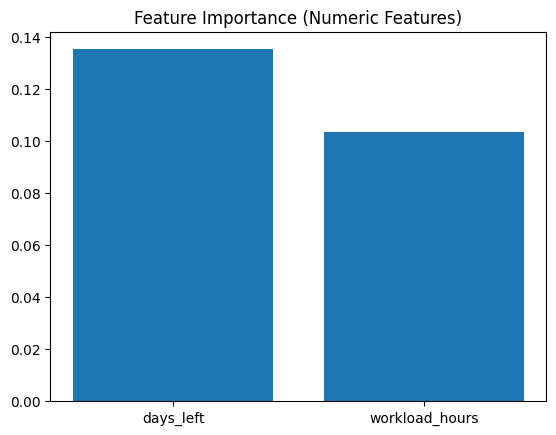

✅ Models saved successfully (priority_model_rf.pkl, tfidf_vectorizer.pkl, numeric_scaler.pkl)


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1️⃣ Load the prepared dataset
# ------------------------------
df = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\AI_Task_Management\Data\tasks_prepared.csv")
print("✅ Loaded dataset with shape:", df.shape)
print("Columns:", df.columns.tolist())

# ------------------------------
# 2️⃣ Feature extraction
# ------------------------------
# Text feature: clean_text  → TF-IDF
vectorizer = TfidfVectorizer(max_features=300)
X_text = vectorizer.fit_transform(df["clean_text"]).toarray()

# Numeric features: days_left + workload_hours
scaler = StandardScaler()
X_num = scaler.fit_transform(df[["days_left", "workload_hours"]])

# Combine all features (text + numeric)
X = np.hstack((X_text, X_num))
y = df["priority_encoded"]

print("✅ Feature matrix shape:", X.shape)

# ------------------------------
# 3️⃣ Train–test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 4️⃣ Train Random Forest model
# ------------------------------
# ------------------------------
# 4️⃣ Train Random Forest model (clean version)
# ------------------------------
from sklearn.metrics import classification_report, accuracy_score
import warnings

# Suppress only undefined metric warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="Precision is ill-defined")

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=7,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("\n🌲 Random Forest Results:")
print(classification_report(y_test, y_pred, zero_division=0))  # 👈 add zero_division=0
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))

# ------------------------------
# 5️⃣ XGBoost model (clean version)
# ------------------------------
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        eval_metric='mlogloss',
        random_state=42
    )
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)

    print("\n🚀 XGBoost Results:")
    print(classification_report(y_test, y_pred_xgb, zero_division=0))  # 👈 add zero_division=0
    print("Accuracy:", round(accuracy_score(y_test, y_pred_xgb), 3))

except ImportError:
    print("⚠️ XGBoost not installed. Run: pip install xgboost")

num_importances = rf.feature_importances_[-2:]
plt.bar(["days_left", "workload_hours"], num_importances)
plt.title("Feature Importance (Numeric Features)")
plt.show()

# ------------------------------
# 7️⃣ Save models & vectorizers
# ------------------------------
joblib.dump(rf, "priority_model_rf.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(scaler, "numeric_scaler.pkl")
print("✅ Models saved successfully (priority_model_rf.pkl, tfidf_vectorizer.pkl, numeric_scaler.pkl)")


In [8]:

# Example: 3 team members with initial workloads (in hours)
users = {
    "User_A": 6,
    "User_B": 4,
    "User_C": 8
}

# Function to assign tasks based on available capacity
def assign_task(task_hours):
    # Find user with minimum current workload
    min_user = min(users, key=users.get)
    users[min_user] += task_hours  # Update their workload
    return min_user

# Apply to each task
df["assigned_user"] = df["workload_hours"].apply(assign_task)

print("✅ Workload Balancing Completed!")
print(df[["clean_text", "workload_hours", "assigned_user"]].head())

# Save updated dataset with assigned users
df.to_csv(r"C:\Users\DELL\OneDrive\Desktop\AI_Task_Management\Data\tasks_with_assignments.csv", index=False)
print("✅ Saved updated dataset as 'tasks_with_assignments.csv'")


✅ Workload Balancing Completed!
                                          clean_text  workload_hours  \
0           annotate training data data pipeline etl               1   
1       create task scheduler documentation handover               3   
2          integrate payment gateway testing qa task               2   
3  fix production bug payment frontend design int...               4   
4     deploy model staging model training evaluation               7   

  assigned_user  
0        User_B  
1        User_B  
2        User_A  
3        User_A  
4        User_B  
✅ Saved updated dataset as 'tasks_with_assignments.csv'


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings

# Suppress only undefined metric warnings
warnings.filterwarnings("ignore", message="Precision is ill-defined")
warnings.filterwarnings("ignore", message="Recall is ill-defined")

# ------------------------------
# 1️⃣ Grid Search
# ------------------------------
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 4, 6]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("\n🔍 Best Parameters Found by GridSearchCV:")
print(grid.best_params_)
print(f"✅ Best Cross-Validation Accuracy: {grid.best_score_:.3f}")

# ------------------------------
# 2️⃣ Evaluate best model on test set
# ------------------------------
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("\n🏆 Tuned Model Evaluation:")
print(classification_report(y_test, y_pred_best, zero_division=0))   # 👈 add zero_division=0
print("Accuracy:", round(accuracy_score(y_test, y_pred_best), 3))


Fitting 3 folds for each of 27 candidates, totalling 81 fits

🔍 Best Parameters Found by GridSearchCV:
{'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 200}
✅ Best Cross-Validation Accuracy: 0.380

🏆 Tuned Model Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        38
           2       0.35      0.15      0.20        62
           3       0.38      0.83      0.52        78

    accuracy                           0.37       200
   macro avg       0.18      0.24      0.18       200
weighted avg       0.25      0.37      0.27       200

Accuracy: 0.37


In [10]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Recreate label encoder and fit to your target column
le = LabelEncoder()
le.fit(df["priority"])  # use the original string column name from your dataset

# Save everything
joblib.dump(best_rf, "final_priority_model.pkl")
joblib.dump(vectorizer, "final_tfidf_vectorizer.pkl")
joblib.dump(scaler, "final_numeric_scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

print("✅ Saved LabelEncoder to label_encoder.pkl")
print("✅ Final models saved successfully!")



✅ Saved LabelEncoder to label_encoder.pkl
✅ Final models saved successfully!


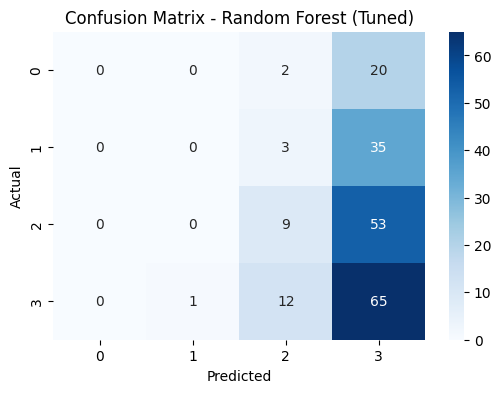

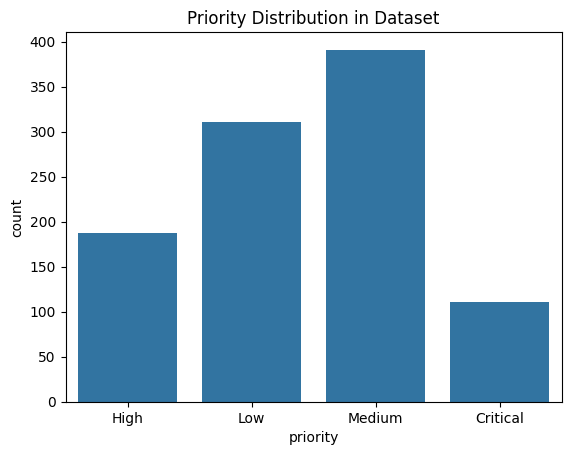

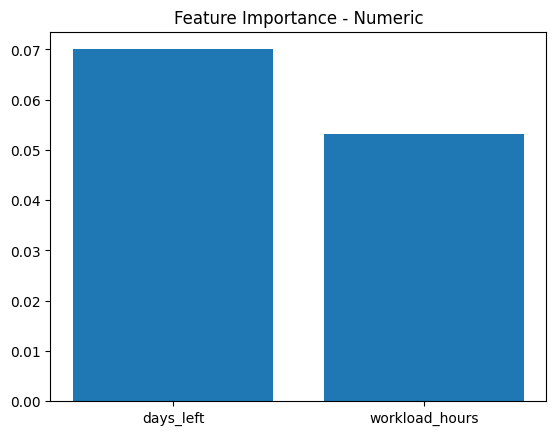

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2️⃣ Priority distribution
sns.countplot(x='priority', data=df)
plt.title("Priority Distribution in Dataset")
plt.show()

# 3️⃣ Feature importance (numeric features)
importances = best_rf.feature_importances_[-2:]
plt.bar(["days_left", "workload_hours"], importances)
plt.title("Feature Importance - Numeric")
plt.show()


In [23]:
import joblib
import numpy as np
import pandas as pd

def predict_priority(task_description, days_left, workload_hours):
    # Load models and preprocessing objects
    model = joblib.load("final_priority_model.pkl")
    vectorizer = joblib.load("final_tfidf_vectorizer.pkl")
    scaler = joblib.load("final_numeric_scaler.pkl")
    le = joblib.load("label_encoder.pkl")  # ✅ Load the original LabelEncoder used during training

    # 1️⃣ Convert text to TF-IDF features
    X_text = vectorizer.transform([task_description]).toarray()

    # 2️⃣ Numeric features → DataFrame (fixes StandardScaler warning)
    X_num = pd.DataFrame([[days_left, workload_hours]], columns=["days_left", "workload_hours"])
    X_num_scaled = scaler.transform(X_num)

    # 3️⃣ Combine all features
    X_input = np.hstack((X_text, X_num_scaled))

    # 4️⃣ Predict encoded label and decode using LabelEncoder
    pred_encoded = model.predict(X_input)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]

    return pred_label

# ✅ Example test
print("Predicted Priority:",
      predict_priority("Complete backend testing and deployment", 3, 5))


Predicted Priority: Medium


In [1]:
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\DELL\Desktop\AI_Task_Management\data


In [2]:
import os

folder = os.getcwd()
print("\nFiles Jupyter sees:\n")
for f in os.listdir(folder):
    print(" -", f)



Files Jupyter sees:

 - .ipynb_checkpoints
 - Dataset.csv
 - final_numeric_scaler.pkl
 - final_priority_model.pkl
 - final_tfidf_vectorizer.pkl
 - label_encoder.pkl
 - naive_bayes_model.pkl
 - numeric_scaler.pkl
 - priority_model_rf.pkl
 - svm_model.pkl
 - Task management.ipynb
 - tasks_cleaned.csv
 - tfidf_vectorizer.pkl
 - Untitled.ipynb
